# 🧠 Predicting Earthquake Origins with Graph Neural Networks

**Author:** Loïc Bachelot  
**Goal:** This notebook demonstrates how to use a GNN to predict the 2D spatial origin of synthetic seismic events from graph-structured input data.

---

## 📘 Overview

Seismic events recorded across a geographic area generate time series data at multiple stations. To model the origin of these events:

1. We treat each seismic station as a **node** in a graph.
2. The **edges** represent relationships (e.g., geographic proximity).
3. The **features** include both the station's location and the recorded signals.

We’ll walk through:
- Creating synthetic data and graph structures
- Building a GNN model (with attention-based pooling)
- Training and evaluating the model
- Visualizing predictions



## 📦 Imports and Setup
We import PyTorch, PyTorch Geometric, and helper libraries used to build and train the GNN.

In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import torch
import torch_geometric
from torch_geometric.transforms import KNNGraph
from torch_geometric.data import InMemoryDataset, Data
from torch.nn import Linear, Parameter, LeakyReLU, Conv2d, MaxPool1d
from torch_geometric.nn import GCNConv, MessagePassing, MLP, GATv2Conv, global_mean_pool, GlobalAttention
from scipy.spatial import distance
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm
from torch import nn
import time


### 🖼️ Visualization Helper Functions

To better understand the structure of the input graphs and the behavior of the signal data, we define two visualization utilities:

1. **`visualize_graph_torch`**  
   This function draws the graph in 2D space:
   - Nodes are colored based on a given feature (e.g., signal amplitude or attention score).
   - Edges are shown as lines connecting nodes.
   - The true event origin is marked with a red ❌.
   - If predictions are available, the model's estimated origin is shown with a blue ❌.

2. **`plot_signals_subplots_by_distance`**  
   This function plots the signal recorded at each station in a separate subplot:
   - Subplots are ordered by the station's distance from the origin.
   - A red dashed line indicates the expected arrival time of the wave.
   - This helps assess whether the signal aligns with physical expectations.

In [2]:
def visualize_graph_torch(g, color, pred=False, ax=None, title=None):
    """
    Visualize the graph structure with PyTorch Geometric graph object.

    Args:
        g (Data): Graph data object with edge_index, pos, and feature color
        color (str): Node attribute key to use for coloring
        pred (bool): If True, also plot predicted origin with blue cross
        ax (matplotlib.axes.Axes, optional): If provided, draw into this axis
        title (str, optional): Optional title to display above plot

    Behavior:
    - Nodes are colored by the specified feature (e.g., signal or attention score)
    - Edges are drawn in blue
    - True origin marked with red ❌
    - Prediction (if enabled) marked with blue ❌
    """
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
        created_fig = True

    # Plot edges
    for edge in g.edge_index.T:
        ax.plot(
            [g.pos[edge[0]][0], g.pos[edge[1]][0]],
            [g.pos[edge[0]][1], g.pos[edge[1]][1]],
            color='blue', linewidth=1
        )

    # Node scatter with color
    scatter = ax.scatter(
        x=g.pos.T[0],
        y=g.pos.T[1],
        alpha=1,
        c=g[color][:, 0],
        s=150
    )

    # True origin
    if hasattr(g, 'y') and g.y[0].numel() == 2:
        ax.plot(g.y[0][0], g.y[0][1], 'rx', markersize=12, markeredgewidth=3)

    # Predicted origin
    if pred and hasattr(g, 'pred') and g.pred[0].numel() == 2:
        ax.plot(g.pred[0][0], g.pred[0][1], 'bx', markersize=12, markeredgewidth=3)

    # Title if given
    if title:
        ax.set_title(title)

    # Clean axes
    ax.set_xticks([])
    ax.set_yticks([])

    # Legend for coloring only once if top-level figure
    if created_fig:
        legend1 = ax.legend(*scatter.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))
        ax.add_artist(legend1)
        plt.show()


def plot_signals_subplots_by_distance(data, velocity=0.5, sampling_rate=1.0, title="Signals by distance to origin"):
    """
    Plot each station's signal in its own subplot, ordered by distance to origin,
    with vertical lines showing the arrival time of the wavefront.

    Args:
        data (Data): PyG Data object with:
            - pos: [num_nodes, 2]
            - signal: [num_nodes, SIGNAL_SIZE]
            - y: [1, 2] or [2] for origin location
        velocity (float): Wave propagation speed (units per second)
        sampling_rate (float): Sample rate (Hz)
        title (str): Title of the figure
    """
    pos = data.pos.cpu().numpy()
    signals = data.signal.cpu().numpy()
    origin = data.y.squeeze().cpu().numpy()

    num_nodes = pos.shape[0]

    # Compute distances from origin and convert to sample index
    distances = np.array([distance.euclidean(origin, pos[i].tolist()) for i in range(num_nodes)])
    arrival_samples = (distances / velocity * sampling_rate).astype(int)
    sort_idx = np.argsort(distances)

    # Plot one subplot per station
    fig, axs = plt.subplots(num_nodes, 1, figsize=(10, 2 * num_nodes), sharex=True)
    for i, idx in enumerate(sort_idx):
        ax = axs[i]
        signal = signals[idx]

        ax.plot(np.arange(len(signal)), signal, color='black', linewidth=1)
        ax.axvline(arrival_samples[idx], color='red', linestyle='--', linewidth=1, label='arrival')
        ax.set_ylabel(f"{distances[idx]:.2f}", rotation=0, labelpad=25)
        ax.grid(True, linestyle='--', alpha=0.3)

    axs[-1].set_xlabel("Time (samples)")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

## 📈 Synthetic Dataset Creation

We simulate synthetic graph-based seismic data to train our Graph Neural Network (GNN). Each graph represents a seismic network where:

- **Nodes** are seismic stations with 2D spatial coordinates.
- **Edges** are created later based on k-nearest neighbors or distance.
- **Signals** at each station are generated as noisy sine waves, delayed in time based on the distance to a hidden origin (the earthquake location).
- **The target (`y`)** for each graph is the 2D coordinate of the origin — the same for all nodes.

### 🧪 Signal Generation Parameters:
- **`nb_nodes ∈ [10, 15]`**: Number of seismic stations per graph.
- **`origin ∈ [0, 6]²`**: The true epicenter is sampled randomly in a 6×6 unit grid.
- **`velocity = 0.5 units/sec`**: Controls how fast the signal propagates from the origin.
- **`sampling_rate = 1.0 Hz`**: Defines the number of samples per unit of time.
- **`noise_std = 0.1`**: Gaussian noise is added to simulate real-world signal variation.
- **`SIGNAL_SIZE`**: Total number of samples in the signal window (e.g., 100).

### 🌀 How are signals delayed?
The signal at each node starts with random noise. Then:
- The time delay is computed as `distance / velocity`
- Converted to a sample index: `delay_samples = delay * sampling_rate`
- A sine wave is inserted at this delayed position in the signal

This creates a physically intuitive training signal: stations farther from the source receive the waveform later in time.

This setup allows the GNN to learn to **infer the origin coordinates** purely from the spatial pattern of waveform arrivals and features across nodes.


In [3]:
def add_edge_weight(g):
    """
    Compute edge weights based on inverse distance between nodes.

    This function adds an 'edge_weight' attribute to each graph,
    calculated as 1 / (distance + 1) to ensure numerical stability.

    Args:
        g (Data): PyG graph with 'pos' and 'edge_index'

    Returns:
        Data: Modified graph with 'edge_weight'
    """
    edge_weight = []
    for edge in g.edge_index.T:
        node_a, node_b = g.pos[edge[0]], g.pos[edge[1]]
        dist = distance.euclidean((node_a[0], node_a[1]), (node_b[0], node_b[1]))
        edge_weight.append(1 / (dist + 1))  # add 1 to avoid division by zero
    g.edge_weight = torch.tensor(np.array(edge_weight)).type(torch.FloatTensor)
    return g


class SinOriginDataset(InMemoryDataset):
    """
    Synthetic dataset for training GNNs to predict origin locations.

    Each graph in the dataset includes:
    - Randomly placed nodes in 2D space.
    - Sine wave signals at each node, delayed by distance from a hidden origin.
    - A regression target: the origin coordinates.

    Args:
        root (str): Root directory to save the processed data
        nb_graph (int): Number of synthetic graphs to generate
    """
    def __init__(self, root, transform=None, pre_transform=None, nb_graph=10):
        self.nb_graph = nb_graph
        super(SinOriginDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        # No raw input files; data is generated from scratch
        return 0

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        data_list = []

        # Dataset parameters
        frequency = 1.0        # Hz
        velocity = 0.5         # wave speed
        sampling_rate = 1.0    # Hz
        noise_std = 0.1        # Gaussian noise level

        # Base sine wave used in signal synthesis
        base_sine_wave = np.sin(np.arange(SIGNAL_SIZE))

        for _ in range(self.nb_graph):
            nb_nodes = np.random.randint(10, 15)  # Graph size
            pos = torch.tensor(np.random.uniform(0, 6, size=(nb_nodes, 2)), dtype=torch.float)  # Node positions
            origin = np.random.randint(0, 6, size=2)  # True origin
            origin_tensor = torch.tensor(origin, dtype=torch.float)

            signal_list = []
            for i in range(nb_nodes):
                dist = distance.euclidean(origin, pos[i].tolist())
                delay = dist / velocity
                delay_samples = int(delay * sampling_rate)

                # Start with noise
                waveform = np.random.normal(0, noise_std, size=SIGNAL_SIZE)

                # Add delayed sine wave if within bounds
                if delay_samples < SIGNAL_SIZE:
                    insert_length = SIGNAL_SIZE - delay_samples
                    waveform[delay_samples:] += base_sine_wave[:insert_length]

                signal_list.append(waveform)

            signal = torch.tensor(np.array(signal_list), dtype=torch.float32).reshape(nb_nodes, SIGNAL_SIZE)
            g = Data(pos=pos, signal=signal, y=origin_tensor.unsqueeze(0))  # y shape: (1, 2)
            data_list.append(g)

        # Apply graph transformations if provided (e.g., KNN, edge weights)
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
            data_list = [add_edge_weight(data) for data in data_list]

        # Save to disk
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [4]:
SIGNAL_SIZE = 20
NB_GRAPHS = 1000

raw_dataset = SinOriginDataset(root="./sin_train", pre_transform=KNNGraph(k=5, loop=False, force_undirected=True), 
                       nb_graph=NB_GRAPHS)
raw_dataset

SinOriginDataset(1000)

### 🔍 Exploring a Graph Sample

Let’s take a look at one sample from our synthetic dataset to understand its structure.

PyTorch Geometric stores each graph in a `Data` object. Here’s what each attribute means:

- **`y=[1, 2]`**: The target — the 2D coordinates of the true origin (shared by all nodes in the graph).
- **`pos=[13, 2]`**: The 2D spatial positions of 13 nodes (i.e., seismic stations).
- **`signal=[13, 20]`**: Each node has a 1D signal of length 20 (e.g., amplitude over time).
- **`edge_index=[2, 74]`**: The graph has 74 directed edges represented as source/target pairs.
- **`edge_weight=[74]`**: Weights for each edge, inversely proportional to spatial distance.

This compact format allows the GNN to process signals in a way that respects the spatial relationships between nodes.

In [5]:
data = raw_dataset[0]
data

Data(y=[1, 2], pos=[13, 2], signal=[13, 20], edge_index=[2, 74], edge_weight=[74])

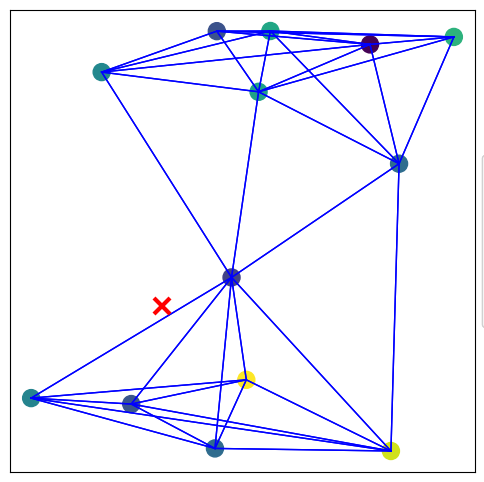

In [6]:
visualize_graph_torch(data, color='signal')

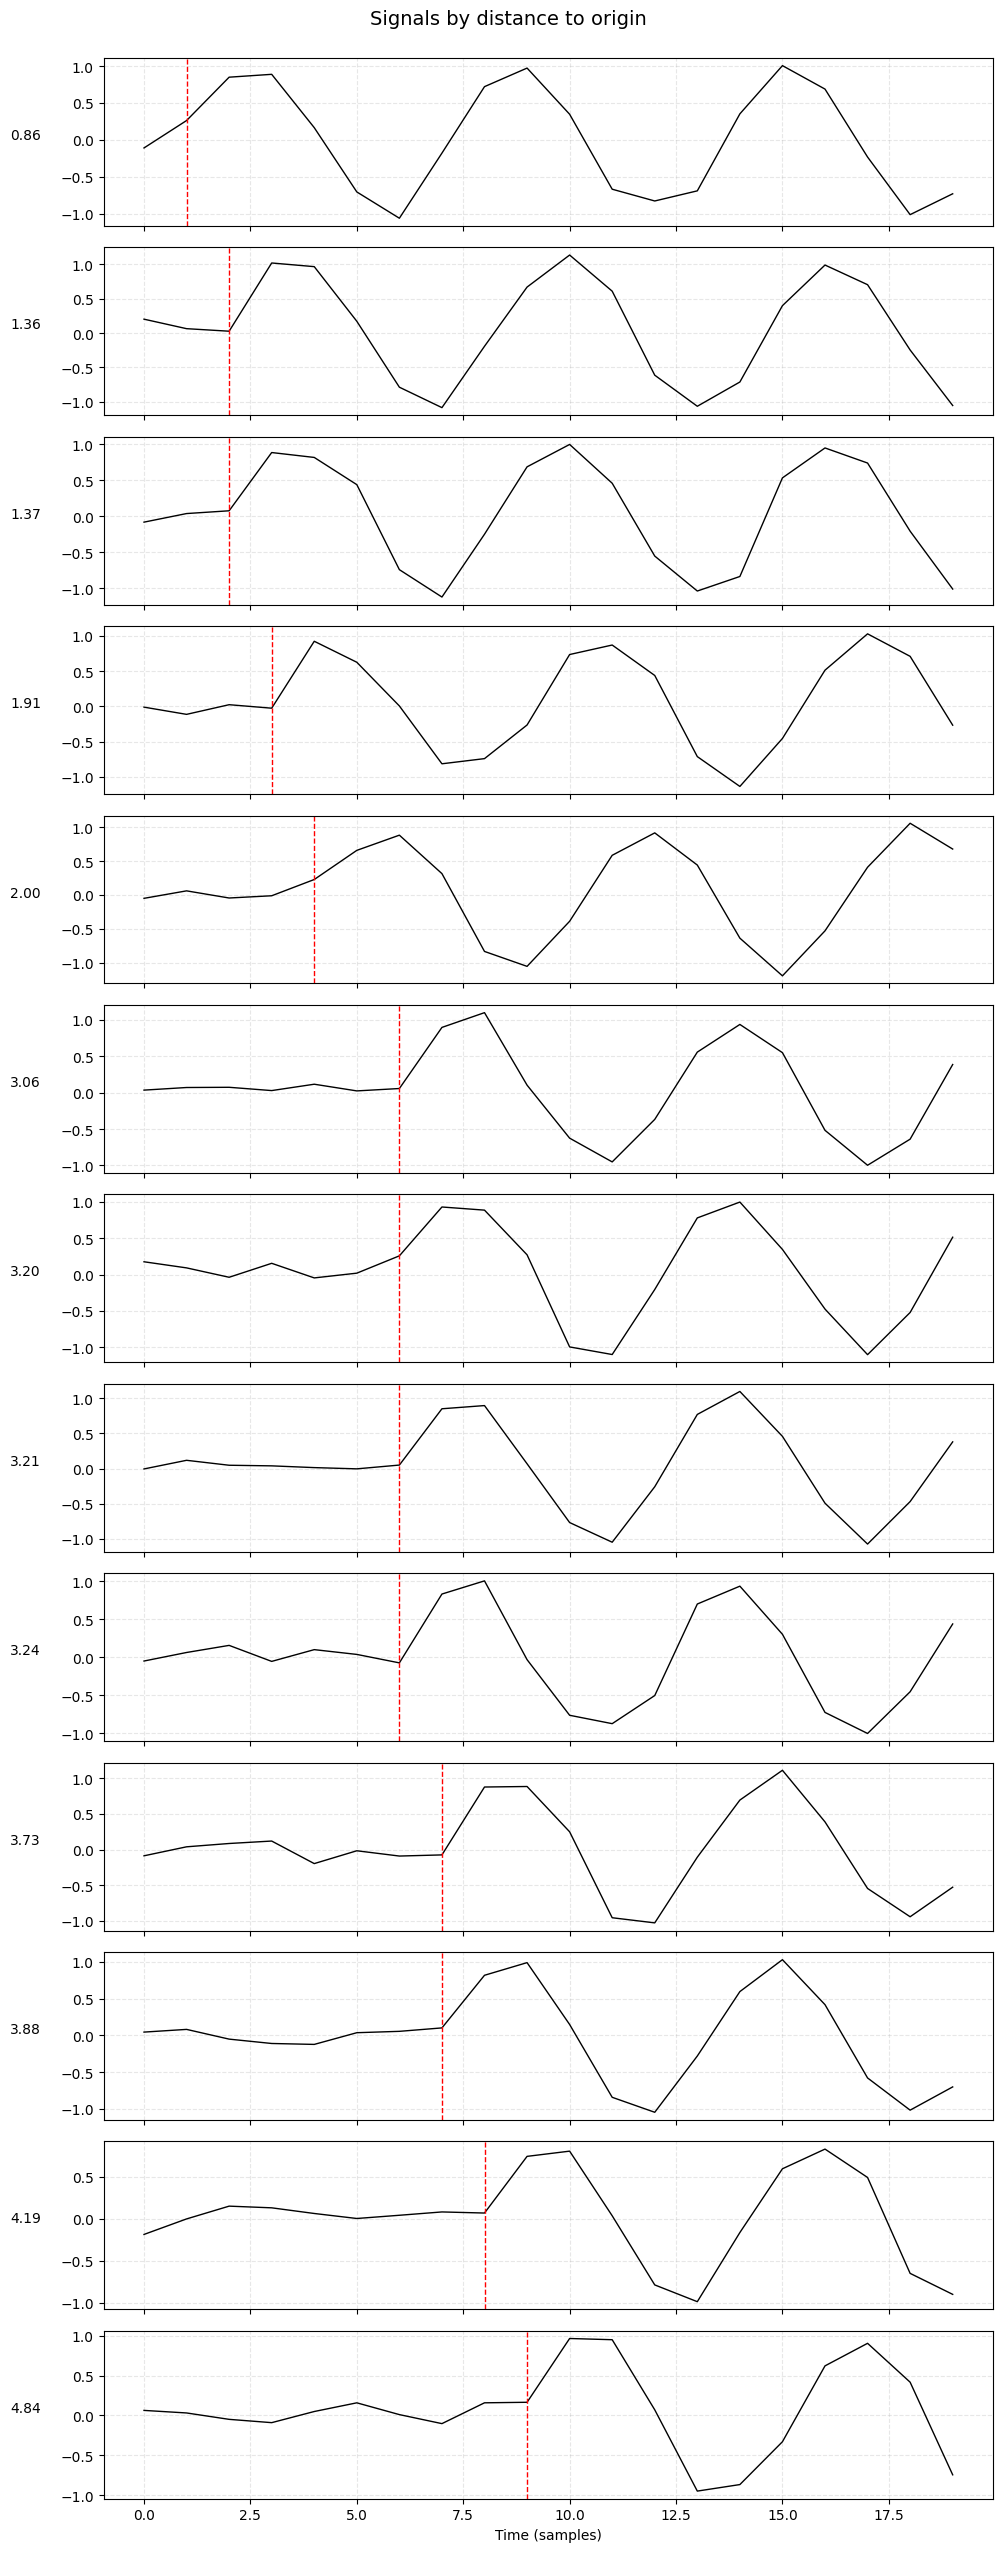

In [7]:
plot_signals_subplots_by_distance(data)

### 🔄 Target Normalization

Before training the model, we normalize the target coordinates (i.e., the true origin) to fall within a standard range.

This is a common preprocessing step in regression problems, especially when using neural networks, because:
- It helps with training stability and convergence.
- Activations remain within consistent ranges.
- The network doesn't need to "learn" scale information from scratch.

We define a wrapper class `NormalizeTargetsWrapper` that rescales the target `y` values from their original coordinate bounds (e.g., [0, 6]) to the range **[-1, 1]**. This normalized range works well with activation functions like `tanh`.

The class also includes a `denormalize()` method, which maps predictions back to the original coordinate space for evaluation and visualization.

In [8]:
class NormalizeTargetsWrapper(torch.utils.data.Dataset):
    """
    Wraps a PyG dataset to normalize `y` from [min_val, max_val] → [-1, 1].
    """
    def __init__(self, dataset, min_val, max_val):
        self.dataset = dataset
        self.min_val = min_val
        self.max_val = max_val

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx].clone()
        # scale from [min, max] to [-1, 1]
        data.y = 2 * (data.y - self.min_val) / (self.max_val - self.min_val) - 1
        return data

    def denormalize(self, norm_y):
        # scale back from [-1, 1] to [min, max]
        return 0.5 * (norm_y + 1) * (self.max_val - self.min_val) + self.min_val

In [9]:
normalized_dataset = NormalizeTargetsWrapper(raw_dataset, min_val=0, max_val=6)

### Train/Validation/Test Split and Batching

We split the dataset into three parts:
- **50%** for training
- **40%** of the remaining for validation
- **10%** for testing

Using `torch_geometric.loader.DataLoader`, we then batch graphs together for efficient training.

#### 🧱 How batching works in PyTorch Geometric:
Unlike image datasets, where each batch is a simple tensor stack, in **PyG**, batching involves:
- Merging node and edge attributes from multiple graphs
- Tracking which nodes belong to which graph using a `batch` vector
- Allowing global pooling operations like `GlobalAttention` to work on per-graph basis

Each batch now behaves like a single big disconnected graph, where GNN layers operate seamlessly across all examples.

We set `batch_size=64` for all splits and enable shuffling only for training.

In [10]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(normalized_dataset, train_size=0.5, random_state=42)
val_dataset, test_dataset = train_test_split(val_dataset, train_size=0.8, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


print(f"nb graph train ds= {len(train_dataset)}, nb graph val ds= {len(val_dataset)}, nb graph test ds= {len(test_dataset)}")

nb graph train ds= 500, nb graph val ds= 400, nb graph test ds= 100


## 🧠 GNN Model Definition: MLPNet

We now define our **graph neural network** model, `MLPNet`, which predicts the origin coordinates of a seismic event from the structure and signals of a graph.

### 🏗️ Architecture Overview:

1. **Input Features**:  
   We concatenate each node’s 2D position with its signal vector.

2. **MLP Encoder (`mlp_in`)**:  
   A multi-layer perceptron (MLP) maps the concatenated input to a hidden representation.

3. **Graph Attention Layers (`conv1`, `conv2`)**:  
   Two `GATv2Conv` layers apply self-attention across neighboring nodes, using edge weights (inversely proportional to distance).  
   > 🔁 *Note:* Only `conv1` is used here; `conv2` is commented out, for model simplification, but showing the possibility to extend the number of message passing layers.

4. **MLP Decoder (`mlp_out`)**:  
   Another MLP refines node embeddings after message passing.

5. **Global Attention Pooling (`att_pool`)**:  
   Aggregates node features into a single graph-level vector using learnable attention weights (via `GlobalAttention`).

6. **Final Linear Output (`out_linear`)**:  
   Predicts a 2D coordinate from the pooled graph representation, constrained to **[-1, 1]** via `tanh()`.

### 📤 Output:
- A single 2D coordinate per graph, representing the model’s **normalized prediction of the origin**.

This architecture combines local (node-level) feature transformations with global (graph-level) aggregation, making it well-suited for spatial inference tasks like epicenter localization.


In [11]:
class MLPNet(torch.nn.Module):
    """
    GNN model with MLP → 2x GATv2Conv → MLP for graph-level origin prediction.

    Args:
        channels_x (int): Positional input features per node.
        channels_y (int): Signal features per node.
        hidden_channels (int): Hidden dimension.
        dropout (float): Dropout probability.
        self_loops (bool): Whether to add self-loops to GATv2Conv.

    Output:
        Tensor of shape (batch_size, 2), normalized origin coordinates (in [-1, 1]).
    """
    def __init__(self, channels_x, channels_y, hidden_channels=128, dropout=0.3, self_loops=True):
        super(MLPNet, self).__init__()
        torch.manual_seed(1234)

        self.mlp_in = MLP([channels_x + channels_y, 64, hidden_channels])

        self.conv1 = GATv2Conv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            heads=2,
            edge_dim=1,
            add_self_loops=self_loops,
            concat=True
        )

        self.conv2 = GATv2Conv(
            in_channels=hidden_channels * 2,  # output of conv1 with 2 heads
            out_channels=hidden_channels,
            heads=2,
            edge_dim=1,
            add_self_loops=self_loops,
            concat=True
        )

        self.mlp_out = MLP([hidden_channels * 2, 64], act=nn.LeakyReLU(), dropout=dropout)

        self.att_pool = GlobalAttention(
            gate_nn=torch.nn.Sequential(
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
        )

        self.out_linear = Linear(64, 2)
        
    def forward(self, pos, signal, edge_index, edge_weight, batch=None):
        x = torch.cat([pos, signal], dim=-1)
        x = self.mlp_in(x)
        x = self.conv1(x, edge_index, edge_weight)
        # x = self.conv2(x, edge_index, edge_weight)
        x = self.mlp_out(x)

        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        graph_repr = self.att_pool(x, batch)
        return self.out_linear(graph_repr).tanh()

## 🚀 Training Loop

This section defines the training and validation routines for our GNN model, as well as a simple early stopping mechanism.

### 🛠️ Helper Functions

Before starting the main loop, we define:

1. **`EarlyStopper`**  
   A utility class to stop training when the validation loss plateaus. It tracks the lowest validation loss seen and stops training if no improvement is observed for a specified number of epochs (`patience`).

2. **`train()`**  
   Runs one full training epoch:
   - Iterates over batched graphs
   - Computes predictions and loss
   - Updates model weights using backpropagation

3. **`validation()`**  
   Evaluates the model on a validation set without updating weights. This is used to monitor overfitting and trigger early stopping.

> ℹ️ Both `train()` and `validation()` rely on:
- The global `model`, `optimizer`, and `criterion`
- Batched data from `torch_geometric.loader.DataLoader`
- `.to(device)` to move data to the appropriate compute device (e.g., GPU)

In [12]:
class EarlyStopper:
    """
    A class for early stopping the training process when the validation loss stops improving.
    """
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train(dataloader, device):
    model.train()
    mean_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        pred = model(data.pos, data.signal, data.edge_index, data.edge_weight, data.batch)  # → shape [num_graphs, 2]

        # Check shape of target
        assert data.y.shape == pred.shape, f"Expected y shape {pred.shape}, got {data.y.shape}"

        loss = criterion(pred, data.y)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
    return mean_loss / len(dataloader)


@torch.no_grad()
def validation(dataloader, device):
    model.eval()
    total_loss = 0
    for data in dataloader:
        data = data.to(device)
        pred = model(data.pos, data.signal, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(pred, data.y)
        total_loss += loss.item()
    return total_loss / len(dataloader)

### ⚙️ Training Setup

Before launching training:
- We select a compute device (GPU if available).
- Instantiate the `MLPNet` model.
- Use **Mean Squared Error (MSE)** as the loss function — ideal for continuous coordinate regression.
- Choose the **Adam optimizer** with a learning rate of `1e-4`.
- Initialize the `EarlyStopper` to monitor validation loss and prevent overfitting.
- Set up a checkpointing path to save the best model based on validation performance.

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = MLPNet(data.pos.shape[1], data.signal.shape[1], hidden_channels=64)

criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Define optimizer.
early_stopper = EarlyStopper(patience=1, min_delta=0.0)
loss_train = []
loss_val = []
best_loss = 1
best_epoch = 0
PATH_CHECKPOINT = "./checkpoint/best_origin_pred.pt"
model

C:\Users\loicb\miniconda3\envs\pangeo_torch\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


MLPNet(
  (mlp_in): MLP(22, 64, 64)
  (conv1): GATv2Conv(64, 64, heads=2)
  (conv2): GATv2Conv(128, 64, heads=2)
  (mlp_out): MLP(128, 64)
  (att_pool): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  ), nn=None)
  (out_linear): Linear(in_features=64, out_features=2, bias=True)
)

### 🔁 Training Loop

The loop runs for up to **5000 epochs**, or until early stopping is triggered. At each epoch:
- We compute and store the training and validation losses.
- Save the model whenever a new best validation loss is observed.
- Use `tqdm` to display a real-time progress bar with current losses.

> 🧠 Note: Early stopping helps avoid unnecessary training once the model stops improving.

In [14]:
start_time = time.perf_counter()
nb_epoch = tqdm(range(5000))

for epoch in nb_epoch:
    loss_train.append(train(train_loader, device))
    loss_val.append(validation(val_loader, device))
    
    if loss_val[-1] < best_loss:
        best_loss = loss_val[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), PATH_CHECKPOINT)
    if early_stopper.early_stop(loss_val[-1]):
        print(f"early stopping at epoch {epoch}: train loss={loss_train[-1]}, val loss={loss_val[-1]}")
        break
    nb_epoch.set_postfix_str(f"train loss={loss_train[-1]}, val loss={loss_val[-1]}")

  1%|▏                 | 44/5000 [00:09<17:59,  4.59it/s, train loss=0.07850025128573179, val loss=0.08444276664938245]

early stopping at epoch 44: train loss=0.07636515330523252, val loss=0.08463311195373535


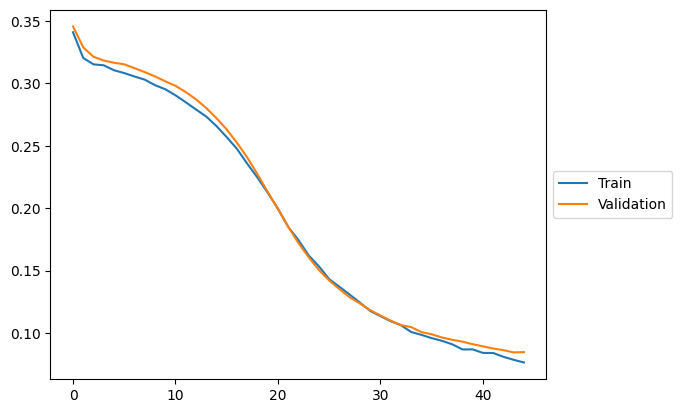

In [15]:
plt.plot(loss_train, label="Train")
plt.plot(loss_val, label = "Validation")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 📈 Model Evaluation

After training, we assess how well the model generalizes to unseen data.

The evaluation process includes:

1. **Load Best Model Checkpoint**  
   We reload the model weights corresponding to the best validation loss during training. This ensures that we evaluate the most performant version of the model, not just the final state.

2. **Visual Inspection on a Few Graphs**  
   We make predictions on a small set of random graphs from the test set.  
   - Visualize predicted vs true origin positions.
   - Get an intuitive feel for typical prediction quality.

3. **Full Test Set Prediction**  
   We then predict on the entire test set to quantify performance over a larger sample.

4. **Compute Simple Metrics**  
   We calculate basic metrics such as:
   - **Mean Absolute Error (MAE)** between predicted and true coordinates
   - Optionally visualize prediction error distributions

> 🧠 This evaluation allows both qualitative (plots) and quantitative (error metrics) understanding of model performance.


In [16]:
# restore best model
# PATH_CHECKPOINT = "./checkpoint/best_origin_pred.pt"
model.load_state_dict(torch.load(PATH_CHECKPOINT))
print(f"best loss={best_loss}, model eval loss={validation(test_dataset, device)} at epoch {best_epoch}")

best loss=0.08444276664938245, model eval loss=0.08298614808358253 at epoch 43


### 🔍 Visualizing Predictions on 9 Test Graphs

To qualitatively evaluate the model’s spatial accuracy, we display predictions on 9 test graphs using a 3×3 grid.

Each subplot shows:
- The graph structure and node positions
- Node coloring based on signal values
- The **true origin** (red ❌) and **predicted origin** (blue ❌)
- The per-sample **Euclidean error** in the title

This visualization helps identify both successful and challenging prediction scenarios.


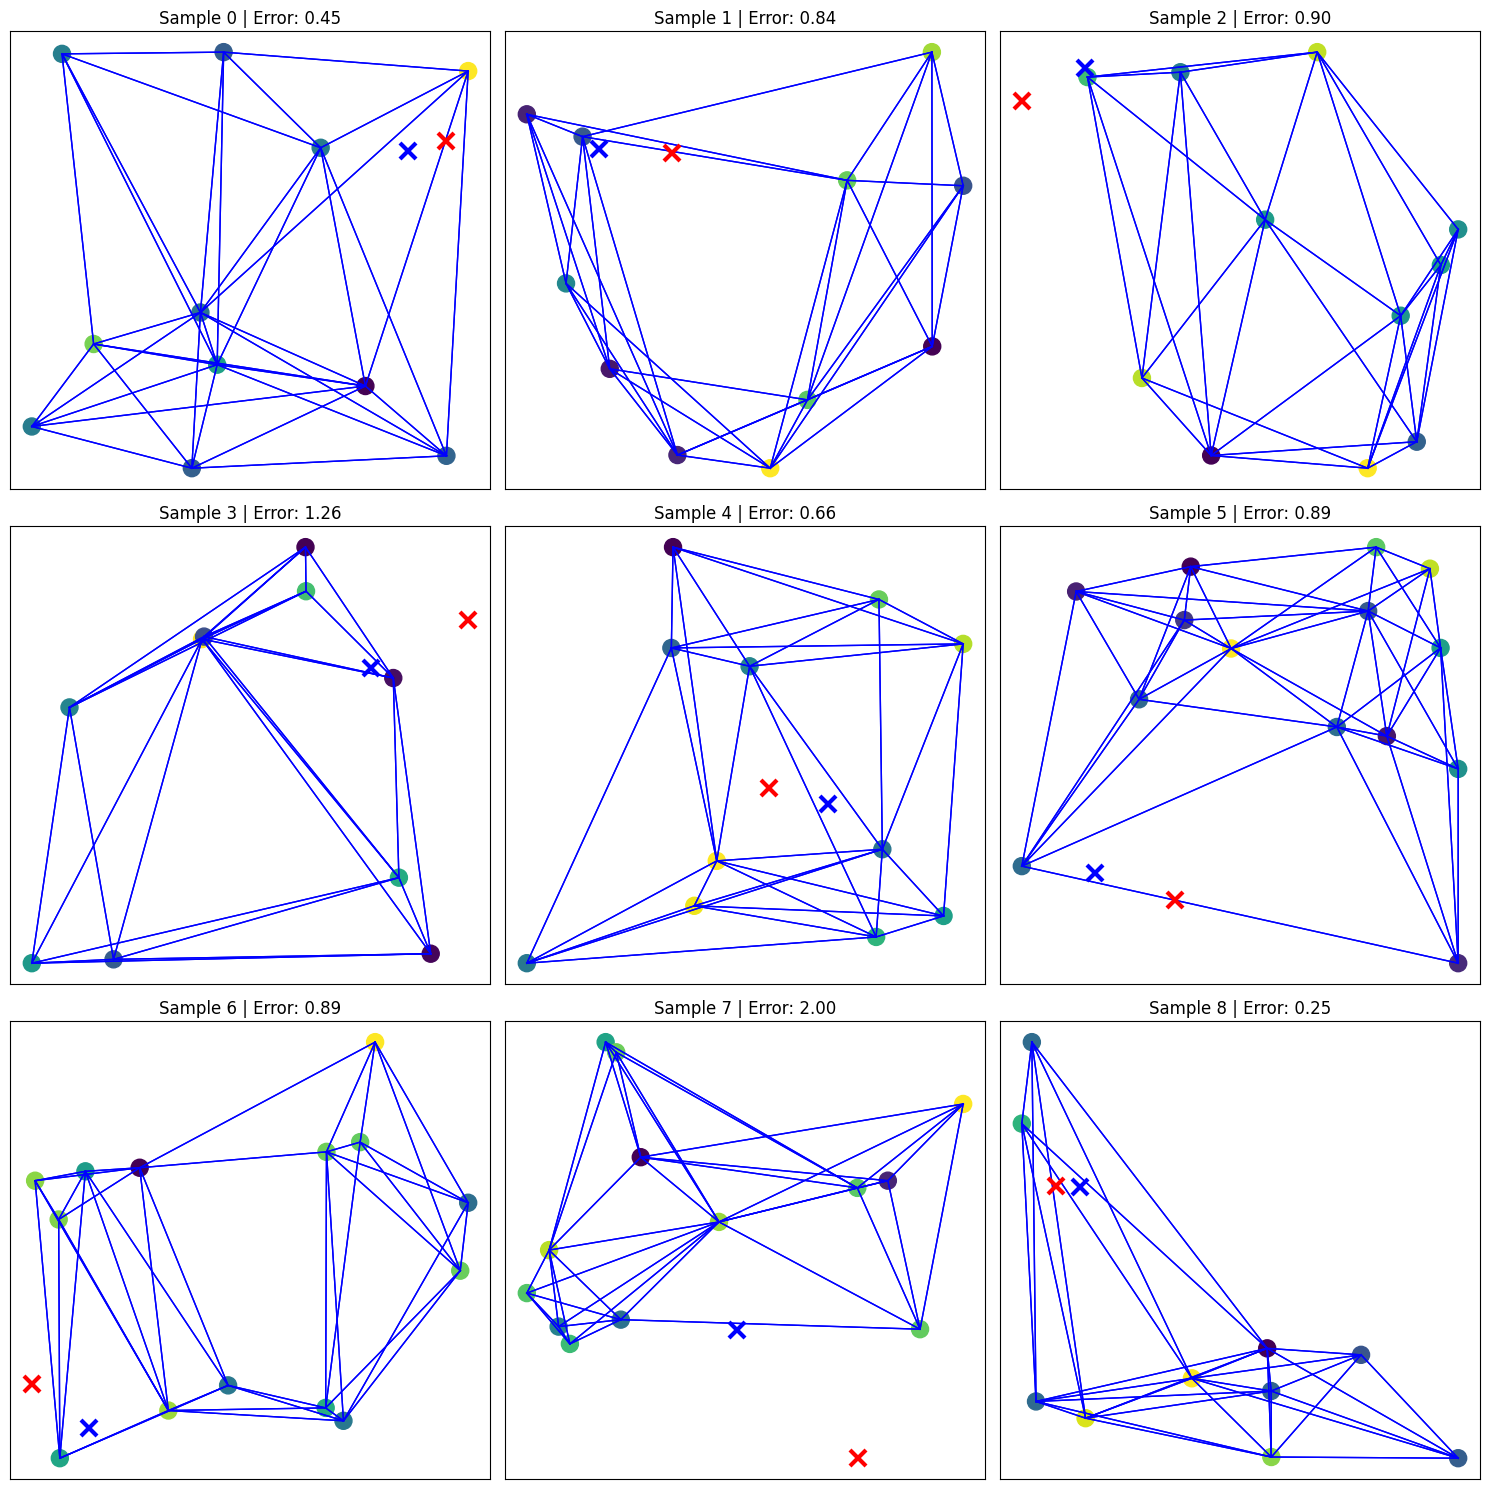

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i in range(9):
    data = test_dataset[i].clone().to(device)

    with torch.no_grad():
        pred = model(data.pos, data.signal, data.edge_index, data.edge_weight, batch=None)

    data.pred = normalized_dataset.denormalize(pred)
    data.y = normalized_dataset.denormalize(data.y)
    data.error = torch.norm(data.pred - data.y, dim=-1).unsqueeze(0)

    ax = axs[i]
    # Custom version of visualize_graph_torch that plots into a given `ax`
    visualize_graph_torch(data, color="signal", pred=True, ax=ax)
    ax.set_title(f"Sample {i} | Error: {data.error.item():.2f}")

plt.tight_layout()
plt.show()

### 📊 Quantitative Evaluation and Error Distribution

We compute a set of quantitative metrics over the full test set to assess the model's predictive accuracy.

#### 🧮 Reported Metrics:
- **MAE (Mean Absolute Error)** for X and Y separately
- **Total MAE** across both dimensions
- **RMSE (Root Mean Squared Error)** — penalizes larger errors more heavily
- **Mean Euclidean Error** — distance between predicted and true origin
- **Max Euclidean Error** — worst-case prediction

These metrics provide a robust summary of how well the model generalizes.

#### 📉 Error Histogram:
We also visualize the distribution of Euclidean errors across all test samples.

A red dashed line shows the **expected error from a random guess**, providing a baseline reference.  
The histogram reveals whether the model consistently predicts near the true origin — or struggles in specific regions.


In [18]:
@torch.no_grad()
def evaluate(model, test_loader, normalized_dataset, device):
    """
    Evaluate model on the full test set and compute error metrics.

    Returns:
        Dict of evaluation metrics
    """
    model.eval()

    pred_all = []
    true_all = []

    for data in test_loader:
        data = data.to(device)
        pred = model(data.pos, data.signal, data.edge_index, data.edge_weight, data.batch)

        pred_denorm = normalized_dataset.denormalize(pred)
        true_denorm = normalized_dataset.denormalize(data.y)

        pred_all.append(pred_denorm.cpu())
        true_all.append(true_denorm.cpu())

    pred_all = torch.cat(pred_all, dim=0)
    true_all = torch.cat(true_all, dim=0)

    abs_errors = torch.abs(pred_all - true_all)
    euclidean_errors = torch.norm(pred_all - true_all, dim=1)

    metrics = {
        "MAE_x": abs_errors[:, 0].mean().item(),
        "MAE_y": abs_errors[:, 1].mean().item(),
        "MAE_total": abs_errors.mean().item(),
        "RMSE": torch.sqrt(((pred_all - true_all) ** 2).mean()).item(),
        "Mean Euclidean Error": euclidean_errors.mean().item(),
        "Max Euclidean Error": euclidean_errors.max().item()
    }

    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")

    return metrics, pred_all, true_all

def plot_error_histogram(pred_all, true_all, bounds=(0, 6), bins=30):
    """
    Plot a histogram of Euclidean errors with optional random baseline.

    Args:
        pred_all (Tensor): shape [N, 2], model predictions (denormalized)
        true_all (Tensor): shape [N, 2], true targets (denormalized)
        bounds (tuple): min/max coordinate bounds for random baseline
        bins (int): histogram bin count
    """
    # Compute Euclidean errors
    errors = torch.norm(pred_all - true_all, dim=1).numpy()

    # Estimate expected error from random predictions in the same domain
    num_samples = len(pred_all)
    rand_preds = torch.rand_like(pred_all) * (bounds[1] - bounds[0]) + bounds[0]
    rand_errors = torch.norm(rand_preds - true_all, dim=1).numpy()
    expected_random_error = rand_errors.mean()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=bins, alpha=0.7, label="Model Prediction Error")
    plt.axvline(expected_random_error, color="red", linestyle="--", linewidth=2,
                label=f"Random baseline: {expected_random_error:.2f}")
    plt.xlabel("Euclidean Error")
    plt.ylabel("Frequency")
    plt.title("Prediction Error Histogram")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

MAE_x: 0.691
MAE_y: 0.686
MAE_total: 0.689
RMSE: 0.864
Mean Euclidean Error: 1.065
Max Euclidean Error: 3.325


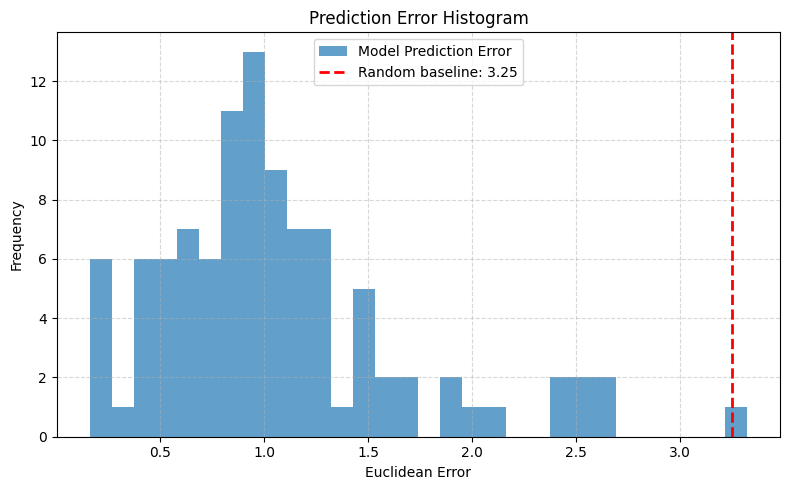

In [19]:
metrics, pred_all, true_all = evaluate(model, test_loader, normalized_dataset, device)

# reuse prediction and truth tensors
plot_error_histogram(pred_all, true_all, bounds=(0, 6))

## ✅ Conclusion

In this notebook, we built and evaluated a Graph Neural Network (GNN) to predict 2D origin coordinates from synthetic seismic-like signals distributed across a spatial graph.

### 🧠 What We Did:
- Generated a toy dataset of sine signals delayed by distance to a hidden origin.
- Encoded both spatial (`pos`) and signal features for each node.
- Used **GATv2Conv** layers and **Global Attention Pooling** to learn graph-level representations.
- Normalized targets for stable training and evaluated with metrics like **MAE** and **RMSE**.
- Visualized predictions at both the graph-level and dataset-level.

### 📊 What We Learned:
- GNNs can effectively model spatial dependencies and delays in signal propagation.
- Attention-based pooling enables flexible aggregation of node-level features.
- Even in a simplified setting, **errors remain spatially structured** — indicating areas where the model struggles (e.g., sparse graphs or boundary cases).

### 🧭 Next Steps:
- Try more complex synthetic scenarios: include signal polarity, noise bursts, or multi-event graphs.
- Use real waveform datasets (e.g., from [SeisBench](https://github.com/seisbench/seisbench)) with station metadata.
- Experiment with alternate architectures: **GINConv**, **Transformer-based pooling**, or **EdgeConv**.
- Add uncertainty estimation or confidence bounds to predictions.

> 🚀 GNNs are powerful tools for modeling geospatial and physical systems — and this notebook is just a start!